In [1]:
# Data Processing
# ----------------

# Import Necessary Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import random
import torch
import torch.nn.functional as F

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the Stock Tickers
# High Volatility Stocks
high_volatility_stocks = ['APA', 'LNC', 'RCL', 'FCX']

# Low Volatility Stocks
low_volatility_stocks = ['GOLD', 'FDP', 'NEM', 'BMY']

# Combined List
tickers = high_volatility_stocks + low_volatility_stocks

# Download Stock Data from Yahoo Finance
start_date = '1999-07-01'
end_date = '2024-07-31'

# Function to download data for a single ticker with error handling
def download_ticker(ticker, start, end):
    try:
        data = yf.download(ticker, start=start, end=end, auto_adjust=False)['Adj Close']
        if data.empty:
            print(f"Warning: No data found for ticker {ticker}.")
            return None
        # Replace zero prices with a small number to prevent division by zero
        data.replace(0, 1e-8, inplace=True)
        return data
    except Exception as e:
        print(f"Error downloading {ticker}: {e}")
        return None

# Download data for each ticker individually
data = pd.DataFrame()
for ticker in tickers:
    ticker_data = download_ticker(ticker, start_date, end_date)
    if ticker_data is not None:
        data[ticker] = ticker_data
    else:
        print(f"Skipping ticker {ticker} due to download issues.")

# Drop tickers with no data
data.dropna(axis=1, how='all', inplace=True)
successful_tickers = data.columns.tolist()

# Check if any data was downloaded
if not successful_tickers:
    raise ValueError("No data was downloaded. Please check the ticker symbols and internet connection.")

# Calculate Features
# Calculate Log Returns
log_returns = np.log(data / data.shift(1)).dropna()

# Calculate RSI2
def calculate_rsi(series, period=2):
    delta = series.diff().dropna()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss.replace(0, 1e-8)  # Replace zero losses to prevent division by zero
    RSI = 100 - (100 / (1 + RS))
    return RSI

rsi2 = data[successful_tickers].apply(calculate_rsi, period=2)

# Combine Features
features_price = data[successful_tickers].copy()
features_rsi2 = rsi2.copy()
features_log_return = log_returns[successful_tickers].copy()

# Create MultiIndex columns
features_price.columns = pd.MultiIndex.from_product([['Price'], features_price.columns])
features_rsi2.columns = pd.MultiIndex.from_product([['RSI2'], features_rsi2.columns])
features_log_return.columns = pd.MultiIndex.from_product([['LogReturn'], features_log_return.columns])

# Concatenate all features
features = pd.concat([features_price, features_rsi2, features_log_return], axis=1)

# Drop rows with any NaN values to ensure complete feature sets
features.dropna(inplace=True)

# Check if features DataFrame is not empty
if features.empty:
    raise ValueError("Features DataFrame is empty after processing. Ensure that the downloaded data contains sufficient information.")

# Initialize Portfolio
initial_cash = 1000000  # Starting with $1,000,000
num_assets = len(successful_tickers)
initial_weights = np.ones(num_assets) / num_assets  # Equal weightage

# Initialize DataFrame to keep track of holdings and cash
portfolio = pd.DataFrame(index=features.index, columns=['Cash'] + successful_tickers)
portfolio.iloc[0]['Cash'] = initial_cash
portfolio.iloc[0][successful_tickers] = 0  # No shares held initially

# Save initial portfolio value
portfolio_values = pd.Series(index=features.index)
portfolio_values.iloc[0] = initial_cash


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
features.head()

Price                                                        \
                  APA        LNC        RCL       FCX       GOLD        FDP   
Date                                                                          
1999-07-06  12.279836  26.820244  31.582680  5.186742  12.607900  10.351245   
1999-07-07  12.146155  27.297924  32.506405  5.223267  12.479244  10.607885   
1999-07-08  12.337130  27.948618  31.670664  5.405898  12.136178  10.351245   
1999-07-09  12.298932  28.258446  31.230782  5.369373  12.350597  10.265697   
1999-07-12  12.127052  28.413387  30.922873  5.205005  12.307709  10.308469   

                                       RSI2             ...             \
                  NEM        BMY        APA        LNC  ...        NEM   
Date                                                    ...              
1999-07-06  11.871778  26.908960  99.999994  92.305715  ...  10.000584   
1999-07-07  11.789044  27.095186  53.334288  93.936064  ...   0.000000   
1999-07-08  11.499491  27.095186  58.823823  99.999998  ...   0.000000   
1999-07-09  11.995875  27.188295  83.332362  99.999998  ...  63.158220   
1999-07-12  11.706315  27.560728   0.000000  99.999996  ...  63.157684   

                      LogReturn                                          \
                  BMY       APA       LNC       RCL       FCX      GOLD   
Date                                                                      
1999-07-06  99.999998  0.012520 -0.001149  0.028251  0.000000 -0.062623   
1999-07-07  99.999995 -0.010946  0.017654  0.028828  0.007017 -0.010257   
1999-07-08  99.999989  0.015601  0.023557 -0.026046  0.034367 -0.027876   
1999-07-09  99.999979 -0.003101  0.011025 -0.013987 -0.006779  0.017514   
1999-07-12  99.999996 -0.014074  0.005468 -0.009908 -0.031091 -0.003479   

                                          
                 FDP       NEM       BMY  
Date                                      
1999-07-06  0.042200 -0.089911  0.006944  
1999-07-07  0.024491 -0.006993  0.006897  
1999-07-08 -0.024491 -0.024868  0.000000  
1999-07-09 -0.008299  0.042260  0.003430  
1999-07-12  0.004158 -0.024434  0.013605  

[5 rows x 24 columns]

In [3]:
successful_tickers

['APA', 'LNC', 'RCL', 'FCX', 'GOLD', 'FDP', 'NEM', 'BMY']

In [4]:
portfolio.head()

,Cash,APA,LNC,RCL,FCX,GOLD,FDP,NEM,BMY
Date,,,,,,,,,
1999-07-06,1000000,0,0,0,0,0,0,0,0
1999-07-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sum(portfolio.iloc[2,])

nan

In [6]:
portfolio.iloc[:,0].value_counts()

Cash
1000000    1
Name: count, dtype: int64

Episode 1: Total Reward = 12286481.59
Episode 2: Total Reward = 12446350.15
Episode 3: Total Reward = 12384001.42
Episode 4: Total Reward = 12461739.31
Episode 5: Total Reward = 12382502.09
Episode 6: Total Reward = 12453053.72
Episode 7: Total Reward = 12422239.34
Episode 8: Total Reward = 12288975.21
Episode 9: Total Reward = 12451683.42
Episode 10: Total Reward = 12496110.78


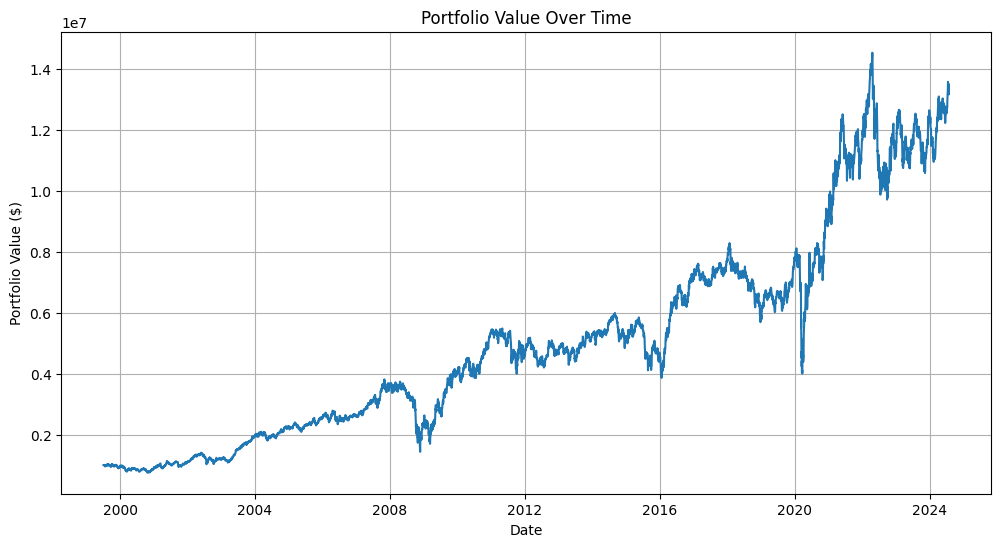

Sharpe Ratio: 0.53


In [7]:

# Model Training
# --------------

# Import Necessary Libraries for Model Training
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Actor and Critic Networks using PyTorch
# Actor Network (Policy Network)
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size=state_dim, hidden_size=100, batch_first=True)
        self.dropout = nn.Dropout(p=0.35)
        self.fc = nn.Linear(100, action_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: [batch_size, sequence_length, state_dim]
        h0 = torch.zeros(1, x.size(0), 100).to(device)
        c0 = torch.zeros(1, x.size(0), 100).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        out = self.sigmoid(out)  # Ensure outputs are between 0 and 1
        return out

# Critic Network (Value Network)
class ValueNetwork(nn.Module):
    def __init__(self, state_dim):
        super(ValueNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size=state_dim, hidden_size=100, batch_first=True)
        self.dropout = nn.Dropout(p=0.35)
        self.fc = nn.Linear(100, 1)

    def forward(self, x):
        # x shape: [batch_size, sequence_length, state_dim]
        h0 = torch.zeros(1, x.size(0), 100).to(device)
        c0 = torch.zeros(1, x.size(0), 100).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# Define the Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size=5000):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = map(np.array, zip(*batch))
        return state, action, reward, next_state

# Ornstein-Uhlenbeck Noise for Exploration
class OUNoise:
    def __init__(self, action_dim, mu=0.0, theta=0.15, sigma=0.2):
        self.action_dim = action_dim
        self.mu = mu * np.ones(self.action_dim)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = np.zeros(self.action_dim)

    def noise(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(self.action_dim)
        self.state += dx
        return self.state

# PPO Agent
class PPOAgent:
    def __init__(self, state_dim, action_dim):
        self.policy = PolicyNetwork(state_dim, action_dim).to(device)
        self.value = ValueNetwork(state_dim).to(device)
        
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=0.0003)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=0.001)
        
        # For compatibility with training loop
        self.replay_buffer = ReplayBuffer()
        self.ou_noise = OUNoise(action_dim)
        
        # PPO hyperparameters
        self.clip_epsilon = 0.2
        self.update_epochs = 5
        
    def get_action(self, state, epsilon):
        # Prepare state
        state_tensor = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device)
        
        # Get action from policy
        self.policy.eval()
        with torch.no_grad():
            action = self.policy(state_tensor).cpu().numpy()[0]
            
            # Add exploration noise if needed
            if np.random.rand() < epsilon:
                action = action + self.ou_noise.noise() * 0.1
                action = np.clip(action, 0, 1)
                
            # Normalize to ensure sum = 1
            action_sum = np.sum(action)
            if action_sum == 0:
                action = np.ones_like(action) / len(action)
            else:
                action /= action_sum
                
        self.policy.train()
        return action
        
    def train(self, batch_size, gamma=0.99):
        if len(self.replay_buffer.buffer) < batch_size:
            return
            
        # Sample transitions from replay buffer
        states, actions, rewards, next_states = self.replay_buffer.sample(batch_size)
        
        # Convert to tensors
        states_tensor = torch.FloatTensor(states).unsqueeze(1).to(device)
        actions_tensor = torch.FloatTensor(actions).to(device)
        rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states_tensor = torch.FloatTensor(next_states).unsqueeze(1).to(device)
        
        # Compute value targets
        with torch.no_grad():
            next_values = self.value(next_states_tensor)
            target_values = rewards_tensor + gamma * next_values
            
        # Get predicted actions from current policy
        old_actions = self.policy(states_tensor).detach()
        
        # PPO update
        for _ in range(self.update_epochs):
            # Compute values
            values = self.value(states_tensor)
            
            # Compute advantages
            advantages = target_values - values
            
            # Normalize advantages
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
            
            # Get current policy actions
            current_actions = self.policy(states_tensor)
            
            # Compute action similarity ratio
            sim_old = -((old_actions - actions_tensor) ** 2).sum(dim=1)
            sim_curr = -((current_actions - actions_tensor) ** 2).sum(dim=1)
            ratio = torch.exp(sim_curr - sim_old)
            
            # Clipped surrogate objective
            surr1 = ratio * advantages.squeeze()
            surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages.squeeze()
            
            # Policy loss
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # Update policy
            self.policy_optimizer.zero_grad()
            policy_loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=0.5)
            self.policy_optimizer.step()
            
            # Value function loss
            value_loss = F.mse_loss(values, target_values)
            
            # Update value function
            self.value_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.value.parameters(), max_norm=0.5)
            self.value_optimizer.step()

# Training Loop
state_dim = 42  # Updated state dimension
action_dim = num_assets  # Number of assets

agent = PPOAgent(state_dim, action_dim)
epsilon = 0.5  # Initial epsilon for epsilon-greedy

num_episodes = 10  # Number of training episodes
batch_size = 64
gamma = 0.99

# Flags to toggle transaction costs
include_transaction_costs = True  # Set to False for PPO without transaction costs

# Initialize previous actions (weights)
prev_actions = np.ones(num_assets) / num_assets  # Start with equal weights

for episode in range(num_episodes):
    agent.ou_noise.reset()
    total_reward = 0
    N_t = 0  # Number of states experienced
    for t in range(1, len(features)):
        # Update epsilon as per the schedule
        if N_t < 1000:
            epsilon = 0.5
        elif 1000 <= N_t < 2000:
            epsilon = 0.25
        else:
            epsilon = 0.1

        # Prepare state
        state_prices = features['Price'].iloc[t-1].values.astype(np.float32)
        state_rsi = features['RSI2'].iloc[t-1].values.astype(np.float32)
        state_log_return = features['LogReturn'].iloc[t-1].values.astype(np.float32)
        state_shares_held = portfolio.iloc[t-1][successful_tickers].values.astype(np.float32)
        state_prev_actions = prev_actions.astype(np.float32)
        state_portfolio_value = np.array([portfolio_values.iloc[t-1]], dtype=np.float32)
        state_cash = np.array([portfolio.iloc[t-1]['Cash']], dtype=np.float32)

        # Handle NaN values if any
        state_prices = np.nan_to_num(state_prices, nan=0.0)
        state_rsi = np.nan_to_num(state_rsi, nan=0.0)
        state_log_return = np.nan_to_num(state_log_return, nan=0.0)
        state_shares_held = np.nan_to_num(state_shares_held, nan=0.0)
        state_prev_actions = np.nan_to_num(state_prev_actions, nan=0.0)
        state_portfolio_value = np.nan_to_num(state_portfolio_value, nan=0.0)
        state_cash = np.nan_to_num(state_cash, nan=0.0)

        # Concatenate all features to form the state vector
        state = np.concatenate([
            state_prices,
            state_rsi,
            state_log_return,
            state_shares_held,
            state_prev_actions,
            state_portfolio_value,
            state_cash
        ])  # Shape: (42,)

        # Get action
        action = agent.get_action(state, epsilon)

        # Calculate transaction costs if applicable
        transaction_cost = 0
        if include_transaction_costs:
            if t > 1:
                # Previous holdings in terms of weights
                prev_holdings = portfolio.iloc[t-1][successful_tickers].values
                prev_prices = data.iloc[t-1][successful_tickers].values
                prev_portfolio_value = portfolio.iloc[t-1]['Cash'] + np.sum(prev_holdings * prev_prices)
                # Prevent division by zero
                if prev_portfolio_value > 0:
                    prev_weights = (prev_holdings * prev_prices) / prev_portfolio_value
                else:
                    prev_weights = initial_weights
            else:
                prev_weights = initial_weights
                prev_portfolio_value = initial_cash  # Define prev_portfolio_value when t <= 1

            # Current weights are the action
            current_weights = action
            # Calculate change in weights
            delta_weights = np.abs(current_weights - prev_weights)
            # Total transaction cost (assuming cost per dollar traded is $0.001)
            transaction_cost = delta_weights.sum() * prev_portfolio_value * 0.001

            # Ensure that transaction cost does not exceed available cash
            transaction_cost = min(transaction_cost, portfolio.iloc[t-1]['Cash'])

        # Update portfolio
        portfolio_value = portfolio.iloc[t-1]['Cash'] + np.sum(portfolio.iloc[t-1][successful_tickers] * data.iloc[t][successful_tickers])
        available_cash = portfolio_value - transaction_cost
        available_cash = max(available_cash, 0)  # Prevent negative cash

        # Allocate new weights
        action_sum = np.sum(action)
        if action_sum == 0:
            # Prevent division by zero
            action = np.ones_like(action) / len(action)
        else:
            action /= action_sum  # Ensure weights sum to 1

        # Update cash after allocating to assets
        portfolio.iloc[t]['Cash'] = available_cash * (1 - action_sum)

        # Prevent division by zero in asset allocation
        asset_prices = data.iloc[t][successful_tickers].values
        asset_prices = np.where(asset_prices == 0, 1e-8, asset_prices)  # Replace zero prices

        # Allocate cash to assets based on the action weights and current prices
        portfolio.iloc[t][successful_tickers] = (available_cash * action) / asset_prices

        # Calculate portfolio value after allocation
        V_t = portfolio.iloc[t]['Cash'] + np.sum(portfolio.iloc[t][successful_tickers] * data.iloc[t][successful_tickers])
        V_t1 = portfolio.iloc[t-1]['Cash'] + np.sum(portfolio.iloc[t-1][successful_tickers] * data.iloc[t-1][successful_tickers])

        # Update portfolio values
        portfolio_values.iloc[t] = V_t

        # Calculate reward
        reward = V_t - V_t1 - transaction_cost

        # Check for NaN values in reward
        if np.isnan(reward):
            print(f"Warning: NaN reward encountered at time step {t}.")
            reward = 0  # Assign zero reward or handle as needed

        # Prepare next state
        next_state_prices = features['Price'].iloc[t].values.astype(np.float32)
        next_state_rsi = features['RSI2'].iloc[t].values.astype(np.float32)
        next_state_log_return = features['LogReturn'].iloc[t].values.astype(np.float32)
        next_state_shares_held = portfolio.iloc[t][successful_tickers].values.astype(np.float32)
        next_state_prev_actions = action.astype(np.float32)  # Current action becomes next state's previous action
        next_state_portfolio_value = np.array([V_t], dtype=np.float32)
        next_state_cash = np.array([portfolio.iloc[t]['Cash']], dtype=np.float32)

        # Handle NaN values if any
        next_state_prices = np.nan_to_num(next_state_prices, nan=0.0)
        next_state_rsi = np.nan_to_num(next_state_rsi, nan=0.0)
        next_state_log_return = np.nan_to_num(next_state_log_return, nan=0.0)
        next_state_shares_held = np.nan_to_num(next_state_shares_held, nan=0.0)
        next_state_prev_actions = np.nan_to_num(next_state_prev_actions, nan=0.0)
        next_state_portfolio_value = np.nan_to_num(next_state_portfolio_value, nan=0.0)
        next_state_cash = np.nan_to_num(next_state_cash, nan=0.0)

        next_state = np.concatenate([
            next_state_prices,
            next_state_rsi,
            next_state_log_return,
            next_state_shares_held,
            next_state_prev_actions,
            next_state_portfolio_value,
            next_state_cash
        ])  # Shape: (42,)

        # Check for NaN in next_state
        if np.isnan(next_state).any():
            print(f"Warning: NaN in next_state at time step {t}. Skipping this step.")
            continue  # Skip storing this transition

        # Store in replay buffer
        agent.replay_buffer.add(state, action, reward, next_state)

        # Train agent
        agent.train(batch_size, gamma)

        total_reward += reward
        N_t += 1

        # Update previous actions
        prev_actions = action.copy()

    print(f"Episode {episode+1}: Total Reward = {total_reward:.2f}")

# Plot Portfolio Value Over Time
plt.figure(figsize=(12,6))
plt.plot(portfolio_values.index, portfolio_values.values)
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time')
plt.grid(True)
plt.show()

# Calculate and Print Sharpe Ratio
# Calculate daily returns
daily_returns = portfolio_values.pct_change().dropna()

# Calculate Sharpe Ratio (assuming risk-free rate is 0)
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)  # Annualized
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")



Performance Metrics:
                          CAGR  Sharpe Ratio  Max Drawdown
PPO                   0.109395      0.525111     -0.623914
Buy and Hold          0.048667      0.311775     -0.644190
CRP                   0.105451      0.511797     -0.625570
Exponential Gradient  0.103044      0.503940     -0.624334
Anticor               0.071998      0.409893     -0.474607
OLMAR                -0.103458     -0.056079     -0.989610
PAMR                 -0.194817     -0.386919     -0.997027
Universal Portfolios  0.104158      0.507494     -0.620401


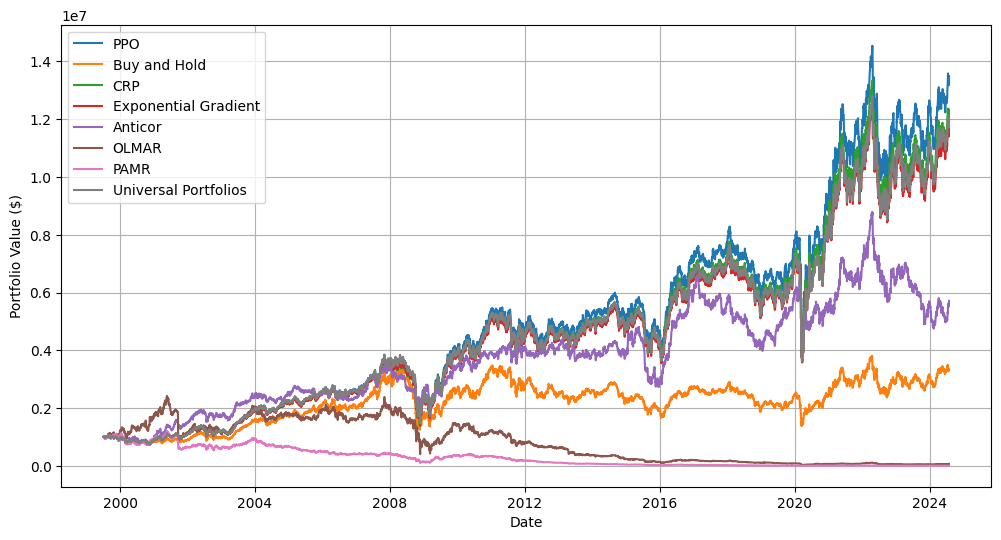

In [8]:
# Benchmark Strategies Implementation
# -----------------------------------

# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialize variables
initial_cash = 1000000  # Starting with $1,000,000
num_assets = len(successful_tickers)
dates = features.index

# Function to calculate performance metrics
def calculate_performance(portfolio_values):
    # Calculate daily returns
    daily_returns = portfolio_values.pct_change().dropna()
    # Calculate CAGR
    total_period = (portfolio_values.index[-1] - portfolio_values.index[0]).days / 365.25
    cagr = ((portfolio_values.iloc[-1] / portfolio_values.iloc[0]) ** (1 / total_period)) - 1
    # Calculate Sharpe Ratio (assuming risk-free rate is 0)
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    # Calculate Maximum Drawdown
    cumulative_returns = (1 + daily_returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdowns = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()
    return cagr, sharpe_ratio, max_drawdown

# 1. Buy and Hold (BAH)
def buy_and_hold():
    portfolio_bah = pd.Series(index=dates)
    # Buy equal amounts of each asset at the beginning
    initial_prices = data.iloc[0][successful_tickers].values
    shares = (initial_cash / num_assets) / initial_prices
    # Calculate portfolio value over time
    for date in dates:
        current_prices = data.loc[date][successful_tickers].values
        portfolio_value = np.sum(shares * current_prices)
        portfolio_bah[date] = portfolio_value
    return portfolio_bah

# 2. Uniform Constant Rebalanced Portfolio (CRP)
def crp():
    portfolio_crp = pd.Series(index=dates)
    cash = initial_cash
    holdings = np.zeros(num_assets)
    for t, date in enumerate(dates):
        current_prices = data.loc[date][successful_tickers].values
        portfolio_value = cash + np.sum(holdings * current_prices)
        # Rebalance to equal weights
        weights = np.ones(num_assets) / num_assets
        desired_holdings = (portfolio_value * weights) / current_prices
        # Calculate trades
        trades = desired_holdings - holdings
        # Update cash considering transaction costs (assuming 0.1% per trade)
        transaction_cost = np.sum(np.abs(trades) * current_prices) * 0.001
        cash -= np.sum(trades * current_prices) + transaction_cost
        holdings = desired_holdings
        portfolio_crp[date] = cash + np.sum(holdings * current_prices)
    return portfolio_crp

# 3. Exponential Gradient (EG)
def exponential_gradient(eta=0.05):
    portfolio_eg = pd.Series(index=dates)
    cash = initial_cash
    holdings = np.zeros(num_assets)
    weights = np.ones(num_assets) / num_assets  # Start with equal weights
    for t in range(len(dates)):
        if t > 0:
            # Calculate price relatives
            prev_prices = data.iloc[t - 1][successful_tickers].values
            current_prices = data.iloc[t][successful_tickers].values
            price_relatives = current_prices / prev_prices
            # Update weights
            numerator = weights * np.exp(eta * price_relatives / np.dot(weights, price_relatives))
            weights = numerator / np.sum(numerator)
        # Rebalance portfolio
        portfolio_value = cash + np.sum(holdings * data.iloc[t][successful_tickers].values)
        desired_holdings = (portfolio_value * weights) / data.iloc[t][successful_tickers].values
        trades = desired_holdings - holdings
        transaction_cost = np.sum(np.abs(trades) * data.iloc[t][successful_tickers].values) * 0.001
        cash -= np.sum(trades * data.iloc[t][successful_tickers].values) + transaction_cost
        holdings = desired_holdings
        portfolio_eg[dates[t]] = cash + np.sum(holdings * data.iloc[t][successful_tickers].values)
    return portfolio_eg

# 4. Anticor (Simplified Version)
def anticor(window_size=30):
    portfolio_anticor = pd.Series(index=dates)
    cash = initial_cash
    holdings = np.zeros(num_assets)
    weights = np.ones(num_assets) / num_assets  # Start with equal weights
    for t in range(len(dates)):
        if t >= window_size:
            # Calculate historical returns
            X = data.iloc[t - window_size:t][successful_tickers].values
            # Compute mean and covariance
            mu = np.mean(X, axis=0)
            cov = np.cov(X.T)
            # Compute anticorrelated weights
            inv_cov = np.linalg.pinv(cov)
            weights = inv_cov @ mu
            weights = np.maximum(weights, 0)  # Ensure non-negative weights
            weights /= np.sum(weights)  # Normalize weights
        # Rebalance portfolio
        portfolio_value = cash + np.sum(holdings * data.iloc[t][successful_tickers].values)
        desired_holdings = (portfolio_value * weights) / data.iloc[t][successful_tickers].values
        trades = desired_holdings - holdings
        transaction_cost = np.sum(np.abs(trades) * data.iloc[t][successful_tickers].values) * 0.001
        cash -= np.sum(trades * data.iloc[t][successful_tickers].values) + transaction_cost
        holdings = desired_holdings
        portfolio_anticor[dates[t]] = cash + np.sum(holdings * data.iloc[t][successful_tickers].values)
    return portfolio_anticor

# 5. Online Moving Average Reversion (OLMAR)
def olmar(window_size=5, epsilon=10):
    portfolio_olmar = pd.Series(index=dates)
    cash = initial_cash
    holdings = np.zeros(num_assets)
    weights = np.ones(num_assets) / num_assets  # Start with equal weights
    for t in range(len(dates)):
        if t >= window_size:
            # Calculate moving average price
            moving_average = data.iloc[t - window_size:t][successful_tickers].mean().values
            current_prices = data.iloc[t][successful_tickers].values
            # Calculate predicted price relatives
            price_relatives = moving_average / current_prices
            # Update weights
            x_bar = np.mean(price_relatives)
            loss = epsilon - np.dot(weights, price_relatives)
            if loss > 0:
                denominator = np.linalg.norm(price_relatives - x_bar) ** 2
                if denominator != 0:
                    lam = loss / denominator
                    weights += lam * (price_relatives - x_bar)
                    weights = np.maximum(weights, 0)
                    weights /= np.sum(weights)
        # Rebalance portfolio
        portfolio_value = cash + np.sum(holdings * data.iloc[t][successful_tickers].values)
        desired_holdings = (portfolio_value * weights) / data.iloc[t][successful_tickers].values
        trades = desired_holdings - holdings
        transaction_cost = np.sum(np.abs(trades) * data.iloc[t][successful_tickers].values) * 0.001
        cash -= np.sum(trades * data.iloc[t][successful_tickers].values) + transaction_cost
        holdings = desired_holdings
        portfolio_olmar[dates[t]] = cash + np.sum(holdings * data.iloc[t][successful_tickers].values)
    return portfolio_olmar

# 6. Passive Aggressive Mean Reversion (PAMR)
def pamr(epsilon=0.5, C=500):
    portfolio_pamr = pd.Series(index=dates)
    cash = initial_cash
    holdings = np.zeros(num_assets)
    weights = np.ones(num_assets) / num_assets  # Start with equal weights
    for t in range(len(dates)):
        if t > 0:
            # Calculate price relatives
            prev_prices = data.iloc[t - 1][successful_tickers].values
            current_prices = data.iloc[t][successful_tickers].values
            price_relatives = current_prices / prev_prices
            # Update weights
            loss = np.maximum(0, np.dot(weights, price_relatives) - epsilon)
            denominator = np.linalg.norm(price_relatives - np.mean(price_relatives)) ** 2
            if denominator != 0:
                tau = np.minimum(C, loss / denominator)
                weights -= tau * (price_relatives - np.mean(price_relatives))
                weights = np.maximum(weights, 0)
                weights /= np.sum(weights)
        # Rebalance portfolio
        portfolio_value = cash + np.sum(holdings * data.iloc[t][successful_tickers].values)
        desired_holdings = (portfolio_value * weights) / data.iloc[t][successful_tickers].values
        trades = desired_holdings - holdings
        transaction_cost = np.sum(np.abs(trades) * data.iloc[t][successful_tickers].values) * 0.001
        cash -= np.sum(trades * data.iloc[t][successful_tickers].values) + transaction_cost
        holdings = desired_holdings
        portfolio_pamr[dates[t]] = cash + np.sum(holdings * data.iloc[t][successful_tickers].values)
    return portfolio_pamr

# 7. Universal portfolio - simplified version
def universal_portfolios():
    portfolio_up = pd.Series(index=dates)
    B = 1000  # Number of sampled portfolios
    weights_list = np.random.dirichlet(np.ones(num_assets), size=B)
    portfolio_values = np.zeros(B)
    portfolio_values[:] = initial_cash
    for t in range(len(dates)):
        current_prices = data.iloc[t][successful_tickers].values
        if t > 0:
            prev_prices = data.iloc[t - 1][successful_tickers].values
            price_relatives = current_prices / prev_prices
            # Update portfolio values
            portfolio_values *= np.dot(weights_list, price_relatives)
        # Average over all portfolios
        portfolio_up[dates[t]] = np.mean(portfolio_values)
    return portfolio_up

# Calculate Portfolio Values for Each Strategy
portfolio_bah = buy_and_hold()
portfolio_crp = crp()
portfolio_eg = exponential_gradient()
portfolio_anticor = anticor()
portfolio_olmar = olmar()
portfolio_pamr = pamr()
portfolio_up = universal_portfolios()

# PPO Agent Portfolio Value (Assuming 'portfolio_values' is from your PPO code)

# Compile Results into a DataFrame
results = pd.DataFrame({
    'PPO': portfolio_values,
    'Buy and Hold': portfolio_bah,
    'CRP': portfolio_crp,
    'Exponential Gradient': portfolio_eg,
    'Anticor': portfolio_anticor,
    'OLMAR': portfolio_olmar,
    'PAMR': portfolio_pamr,
    'Universal Portfolios': portfolio_up
})

# Calculate Performance Metrics
metrics = {}
for strategy in results.columns:
    cagr, sharpe, max_drawdown = calculate_performance(results[strategy])
    metrics[strategy] = {
        'CAGR': cagr,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_drawdown
    }

metrics_df = pd.DataFrame(metrics).T

# Print Performance Metrics
print("\nPerformance Metrics:")
print(metrics_df)

# Plot Portfolio Values Over Time
plt.figure(figsize=(12, 6))
for strategy in results.columns:
    plt.plot(results.index, results[strategy], label=strategy)
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
# plt.title('Portfolio Value Over Time for Different Strategies')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
data.shape

(6310, 8)